In [1]:
import sys
packages = [
    '../dataset/',
    '../utils/',
    '../optimizer/',
    '../loss/',
    '../model/',
    '../patchNet'
]
sys.path.extend(packages)
from sklearn.model_selection import KFold
from tqdm import tqdm
from brpnet.model import UNet
# from patch_dense_net import UNet
from loss import dice_loss, smooth_truncated_loss, compute_loss_list
from adamw_r.cyclic_scheduler import CyclicLRWithRestarts, ReduceMaxLROnRestart
from adamw_r.adamw import AdamW
from ImageProcess.ImgShow import showLineImg
from dataset.PathologyData import PathologyDataSet
from dataset.InstanceDataset import InstanceDataset
import cv2
import torch.nn.functional as F
import time
import torch
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn as nn
from postProcess.post_proc import post_proc,getInstancePosi,getInstanceArray
# 首先先对图片进行染色归一化处理
from StainProcess.StainNormalization import normalizeStaining
from ImageProcess.ImageProcess import cv2Bgr2Rgb
from DataUtil import kfold_list
from util import getNowTime,transformImg,extract_patches,reconstruct_from_patches_weightedall,test_extract_patches
from scipy import ndimage




In [2]:
def infer(model,device,image):
    batch_size = 1
    aug_list = ['ori', 'rot90', 'rot180', 'rot270', 'flip_h', 'flip_w']
    image_tensor = torch.FloatTensor(image)
    image_tensor = image_tensor.unsqueeze(dim=0)
    image_tensor = image_tensor.permute(0,3,1,2)
    # (0,3,1000,1000)
    # print('image_tensor: ',image_tensor.shape)
    img_num,c,h,w = image_tensor.shape
    patches_d, ibs, shs, sws = extract_patches(image_tensor,256,128)
    sigmoid = nn.Sigmoid()
    # 定义最后的结果
    finalsout = np.zeros([1, h, w], dtype=np.float32)
    finalcout = np.zeros([1, h, w], dtype=np.float32)
    # tta操作
    for type_aug in aug_list:
        if type_aug == 'ori':
            tta_d = patches_d.clone()
        if type_aug == 'rot90':
            tta_d = patches_d.rot90(1, dims=(2,3))
        if type_aug == 'rot180':
            tta_d = patches_d.rot90(2, dims=(2,3))
        if type_aug == 'rot270':
            tta_d = patches_d.rot90(3, dims=(2,3))
        if type_aug == 'flip_h':
            tta_d = patches_d.flip(2)
        if type_aug == 'flip_w':
            tta_d = patches_d.flip(3)
        # 
        spred = torch.zeros(tta_d.shape[0],1,tta_d.shape[2],tta_d.shape[3])
        cpred = torch.zeros(tta_d.shape[0],1,tta_d.shape[2],tta_d.shape[3])

        for start_batch in list(range(0,tta_d.shape[0],batch_size)):
            end_batch = np.min([start_batch + batch_size, tta_d.shape[0]])
            input_d = tta_d[start_batch:end_batch]
            if len(input_d.shape) == 3:
                input_d = input_d.unsqueeze(dim=0)
            input_d = input_d.to(device)
            outs = model(input_d)
            sout = outs[0]
            cout = outs[5]
            # sigmod的原因在于将一些负数压制到0，然后相减的时候就可以直接操作了
            spred[start_batch:end_batch] = sigmoid(sout).data.cpu()
            cpred[start_batch:end_batch] = sigmoid(cout).data.cpu()
        # Inverse TTA
        if type_aug == 'rot90':
            spred = spred.rot90(3, dims=(len(spred.shape)-2,len(spred.shape)-1))
            cpred = cpred.rot90(3, dims=(len(cpred.shape)-2,len(cpred.shape)-1))
        elif type_aug == 'rot180':
            spred = spred.rot90(2, dims=(len(spred.shape)-2,len(spred.shape)-1))
            cpred = cpred.rot90(2, dims=(len(cpred.shape)-2,len(cpred.shape)-1))
        elif type_aug == 'rot270':
            spred = spred.rot90(1, dims=(len(spred.shape)-2,len(spred.shape)-1))
            cpred = cpred.rot90(1, dims=(len(cpred.shape)-2,len(cpred.shape)-1))
        elif type_aug == 'flip_h':
            spred = spred.flip(len(spred.shape)-2)
            cpred = cpred.flip(len(cpred.shape)-2)
        elif type_aug == 'flip_w':
            spred = spred.flip(len(spred.shape)-1)
            cpred = cpred.flip(len(cpred.shape)-1)
        #
        spred_map = reconstruct_from_patches_weightedall(spred, ibs, shs, sws, 256, 128, img_num, 1, w, h, 1).squeeze().numpy()
        cpred_map = reconstruct_from_patches_weightedall(cpred, ibs, shs, sws, 256, 128, img_num, 1, w, h, 1).squeeze().numpy()
        #
        finalsout += spred_map
        finalcout += cpred_map

    finalsout /= len(aug_list)
    finalcout /= len(aug_list)
    # 神经网络输出的结果
    return finalsout,finalcout



True

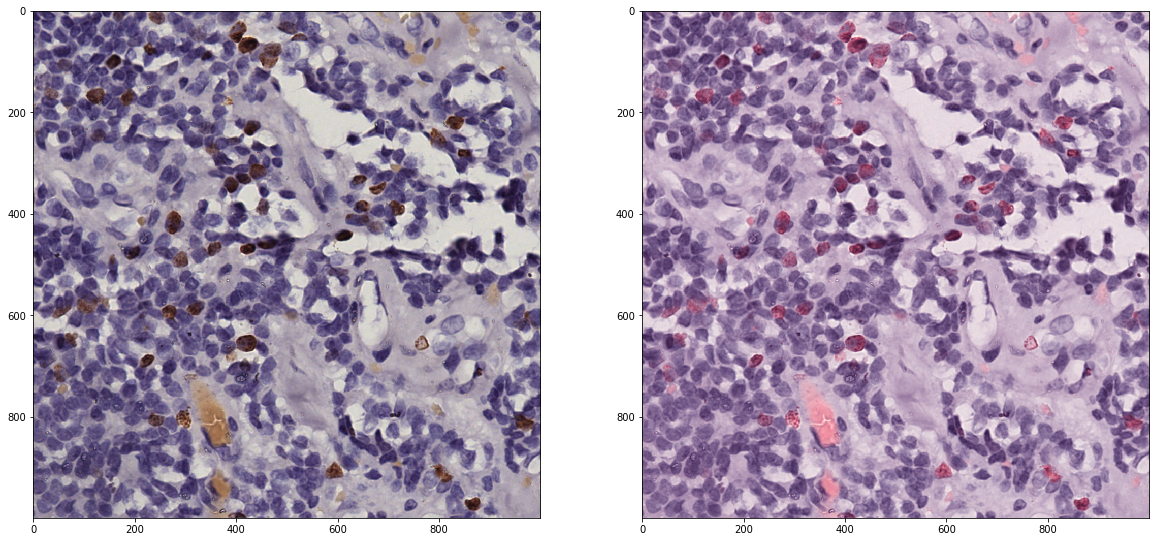

In [7]:
slideImg = cv2Bgr2Rgb('slideImage00.png')
img_input = slideImg[500:1500,2000:3000]
img_input_norm,_,_ = normalizeStaining(img_input)

showLineImg([img_input,img_input_norm],figsize=(20,20))

img_input = cv2.cvtColor(img_input,cv2.COLOR_RGB2BGR)
cv2.imwrite('img_input_1000.jpg',img_input)


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(3,1,1).to(device)
model.load_state_dict(torch.load('../train_model/model_of_360.pth'))

<All keys matched successfully>

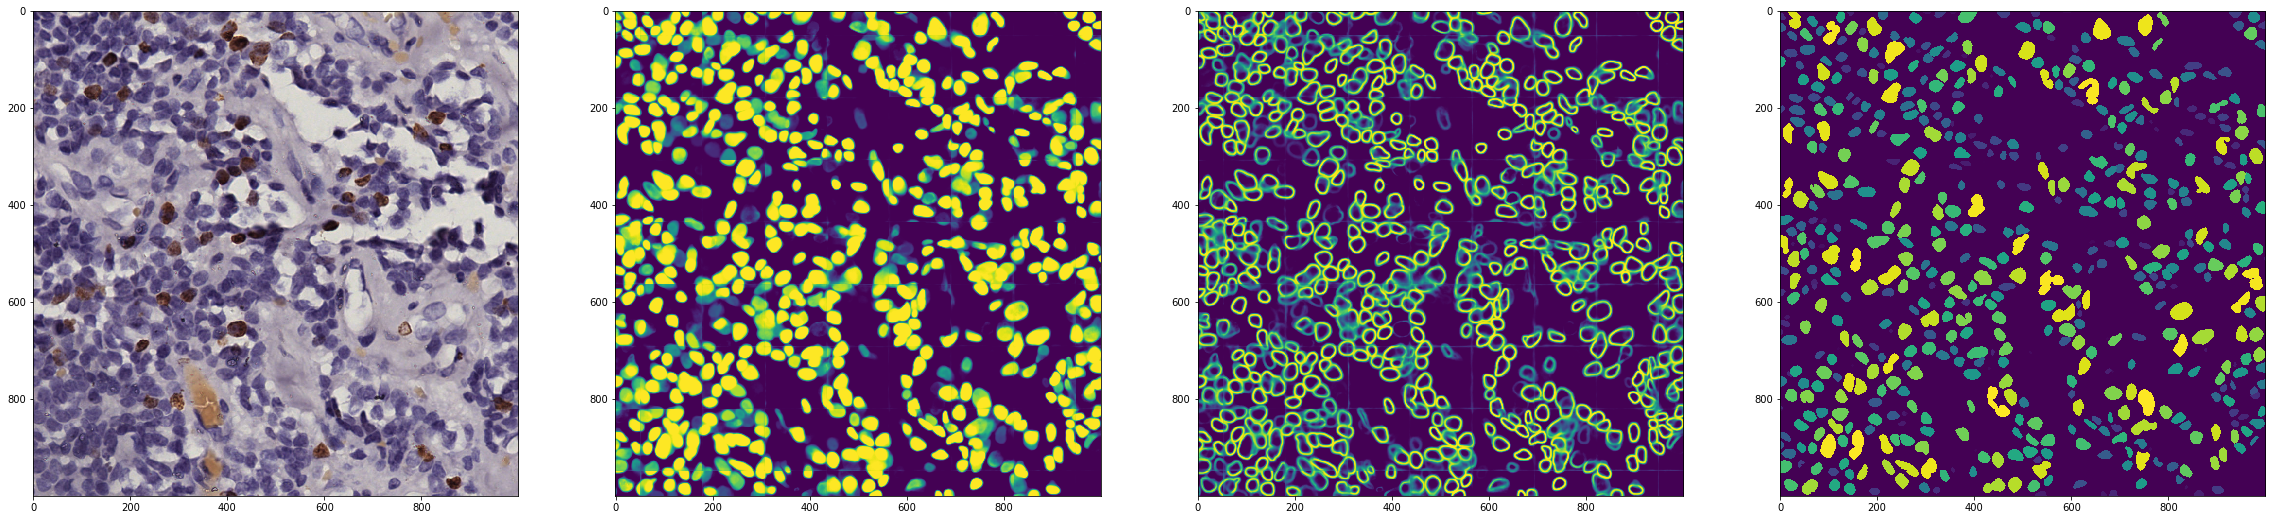

In [8]:
sout,cout = infer(model,device,img_input_norm)
pred = post_proc(sout-cout)
showLineImg([img_input,sout[0],cout[0],pred[0]],figsize=(40,40))

In [9]:
pred0 = pred[0]
img_input = img_input.astype('float32')
pred0 = pred0.astype('float32')
pred0[pred0 != 0] = 255
print(img_input.shape,pred0.shape)
showLineImg([img_input,pred0])

(1000, 1000, 3) (1000, 1000)


In [10]:
pred0_result = np.zeros((3,1000,1000),dtype = np.float32)
print(pred0_result.shape)


(3, 1000, 1000)


In [11]:
pred0_result[0] = pred0

pred0_result_trans = np.transpose(pred0_result,(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


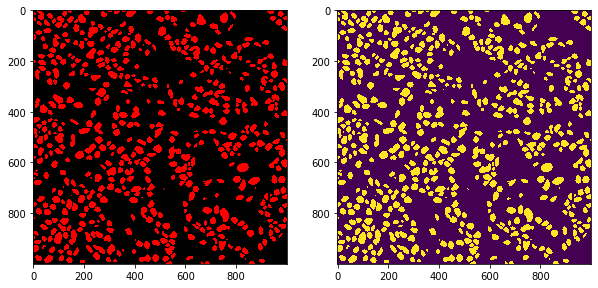

In [12]:
showLineImg([pred0_result_trans,pred0_result[0]])

In [13]:
result = cv2.add(img_input,pred0_result_trans)

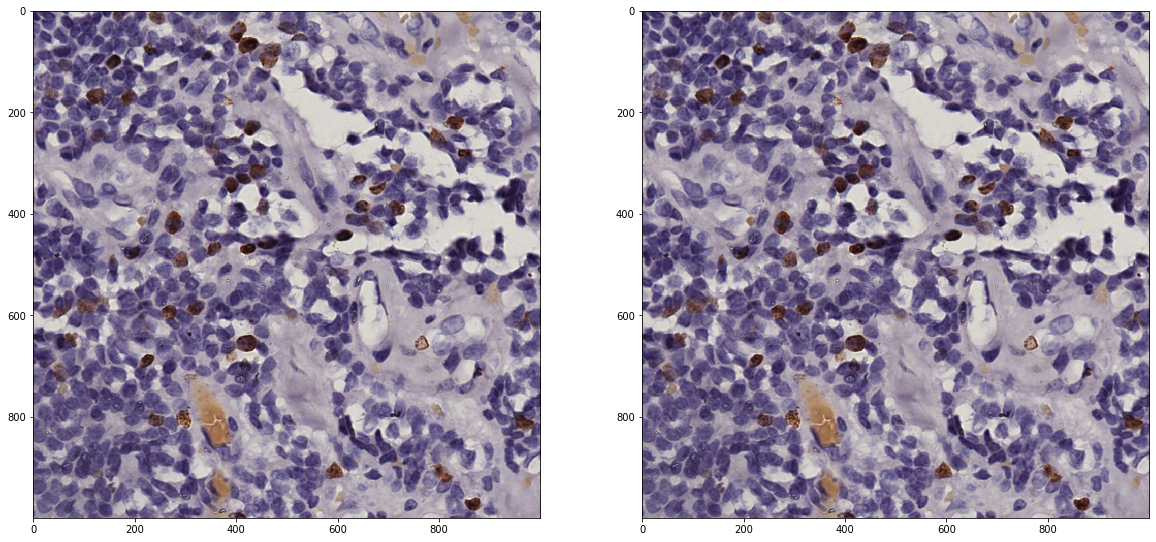

In [14]:
result = result.astype('uint8')
showLineImg([result,result],figsize=(20,20))
